### Config

In [1]:
c_random_state = 22

### Imports

In [2]:
import os
import spacy
import gensim
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

2024-02-27 06:09:28.948465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 06:09:28.948566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 06:09:29.096954: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Code

In [8]:
def get_and_preprocess_data(percent = 1.0):
    """
    Read the datasets.
    Split the training dataset into training and validation dataset - 90:10 split
    """
    
    def preprocess(df):
    
        def clean_text(article):
            """
            Do basic preprocessing
                1. Converting to lower case
                2. Removing special characters
                3. Removing stop words
                4. Lemmatization
                5. Removing most common words
            Note: Transformer models have BPE and stop word removal, but just to reduce the training time, stopwords have been removed.
            """
            article = gensim.utils.simple_preprocess(doc = article, deacc = True, min_len = 2)
            doc = nlp(' '.join(article))
            words_list = [token.lemma_ for token in doc if not token.is_stop]
            article = ' '.join([word for word in set(words_list) if word not in custom_stop_words])
            return article
        
        df['text'] = df['title'] + " " + df['desc']
        df['label'] = df['label'].astype('category').cat.codes
        df['text'] = df['text'].apply(clean_text)
        df = df[['text', 'label']]
        return df

    df_train = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', names = ['label', 'title', 'desc'], header = 0)
    df_test = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', names = ['label', 'title', 'desc'], header = 0)

    custom_stop_words = ['quot', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'yesterday', 'today', 'tomorrow',
                        'say', 'tell', 'new', 'people', 'also', 'time']
    if percent != 1.0:
        train_class_samples, test_class_samples = int(percent * 0.25 * len(df_train)), int(percent * 0.25 * len(df_test))
        temp_train, temp_test = pd.DataFrame(), pd.DataFrame()
        unique_labels = list(df_train['label'].unique())

        for lbl in unique_labels:
            a = df_train[df_train.label == lbl][:train_class_samples]
            b = df_test[df_test.label == lbl][:test_class_samples]
            temp_train = pd.concat([temp_train, a], axis = 0)
            temp_test = pd.concat([temp_test, b], axis = 0)

        df_train = temp_train.copy()
        df_test = temp_test.copy()

    df_train, df_valid = train_test_split(df_train, test_size = 0.1, random_state = c_random_state)
    
    nlp = spacy.load('en_core_web_sm')
    df_train = preprocess(df_train)
    df_valid = preprocess(df_valid)
    df_test = preprocess(df_test)

    return df_train, df_valid, df_test


def reformat_data(tokenizer, df_train_, df_valid_):
    
    """
    Reformat the data and convert it to a format compatible with tensorflow model.
    """

    def build_dataset(feature_encodings, labels):
        return tf.data.Dataset.from_tensor_slices((dict(feature_encodings), labels))


    X_train_enc = tokenizer(df_train_['text'].tolist(), padding = True, truncation = True)
    X_valid_enc = tokenizer(df_valid_['text'].tolist(), padding = True, truncation = True)

    y_train = df_train_['label'].tolist()
    y_valid = df_valid_['label'].tolist()

    dataset_train = build_dataset(X_train_enc, y_train)
    dataset_valid = build_dataset(X_valid_enc, y_valid)

    tokenized_dataset = {'train': dataset_train, 'validation': dataset_valid}

    return tokenized_dataset


def load_requirements():
    
    """
    Load pretrained model and tokenizer from transformers library.
    Configure the optimizer and compile the model
    Using low learning rate to avoid catastrophic forgetting.
    """
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 4)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5)
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    return tokenizer, model


def get_callbacks():
    """
    Callbacks for model training
    Early Stopping and Checkpointing
    """
    return [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 2, min_delta = 0.0001),
        tf.keras.callbacks.ModelCheckpoint(filepath = f'/kaggle/working/chkpt/weights.h5',
                                           save_weights_only = True, monitor = 'val_loss',
                                           mode = 'min', save_best_only = True)
        ]

def train_model(model_, dataset_, n_epochs_, batch_size_):
    """
    Fine-tune the model with the custom dataset by training the model for a certain number of epochs.
    """
    train_history = model_.fit(dataset_['train'].shuffle(100).batch(batch_size_),
                               epochs = n_epochs_,
                               batch_size = batch_size_,
                               validation_data = dataset_['validation'].shuffle(100).batch(batch_size_),
                               callbacks = get_callbacks()
                               )
    return model_, train_history


def plot_training(history):
    """
    Plot the model training stats
    """
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

    for idx, metric in enumerate(['accuracy', 'loss']):
        axes[idx].plot(history.history[metric])
        axes[idx].plot(history.history[f'val_{metric}'])
        axes[idx].set_title(f'Model {metric.title()}')
        axes[idx].set_ylabel(metric.title())
        axes[idx].set_xlabel('Epoch')
        axes[idx].legend(['Train', 'Validation'], loc = 'upper left')

    plt.tight_layout()
    plt.show()
    
    
def make_preds(text):
    """
    Make predictions
        1. Tokenize the test data using the same tokenizer used for training and validation datasets.
        2. Obtain prediction probabilities.
        3. Find the predicted labels by taking argmax of the probabilities.
    """
    inputs = tokenizer(text, padding = True, truncation = True, return_tensors = "tf")
    outputs = news_classifier(inputs)
    predicted_label = tf.argmax(outputs.logits, axis = 1).numpy().item()
    return predicted_label


def plot_confusion_matrix(x):
    
    """
    Plot confusion matrix
    """
    
    conf_matx = confusion_matrix(x['label'], x['prediction'])
    conf_matx = pd.DataFrame(conf_matx, index = ["0", "1", "2", "3"], columns = ["0", "1", "2", "3"])
    plt.figure(figsize = (5, 5))
    cfm_plot = sns.heatmap(conf_matx, annot = True)
    plt.show()
    
    
def get_f1_score(x):
    
    """
    No class imbalance - so using macro average.
    """
    
    f1score_macro = f1_score(x['label'], x['prediction'], average = 'macro')
    f1score_micro = f1_score(x['label'], x['prediction'], average = 'micro')
    return {'macro': f1score_macro, 'micro': f1score_micro}


### Driver

In [4]:
c_epochs = 5
df_train, df_valid, df_test = get_and_preprocess_data(percent = 0.1)
tokenizer, model = load_requirements()

dataset = reformat_data(tokenizer, df_train, df_valid)
news_classifier, train_history = train_model(model_ = model, dataset_ = dataset, n_epochs_ = c_epochs, batch_size_ = 32)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5


I0000 00:00:1709014374.356970      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


338/338 [==============================] - 105s 221ms/step - loss: 1.0551 - accuracy: 0.7107 - val_loss: 0.6586 - val_accuracy: 0.8125
Epoch 2/5
338/338 [==============================] - 73s 216ms/step - loss: 0.5859 - accuracy: 0.8520 - val_loss: 0.5906 - val_accuracy: 0.8558
Epoch 3/5
338/338 [==============================] - 72s 214ms/step - loss: 0.5808 - accuracy: 0.8281 - val_loss: 0.6156 - val_accuracy: 0.8475
Epoch 4/5
338/338 [==============================] - 73s 216ms/step - loss: 0.5089 - accuracy: 0.8875 - val_loss: 0.4521 - val_accuracy: 0.8800
Epoch 5/5
338/338 [==============================] - 72s 214ms/step - loss: 0.5930 - accuracy: 0.7898 - val_loss: 0.7200 - val_accuracy: 0.8592


### Training Stats

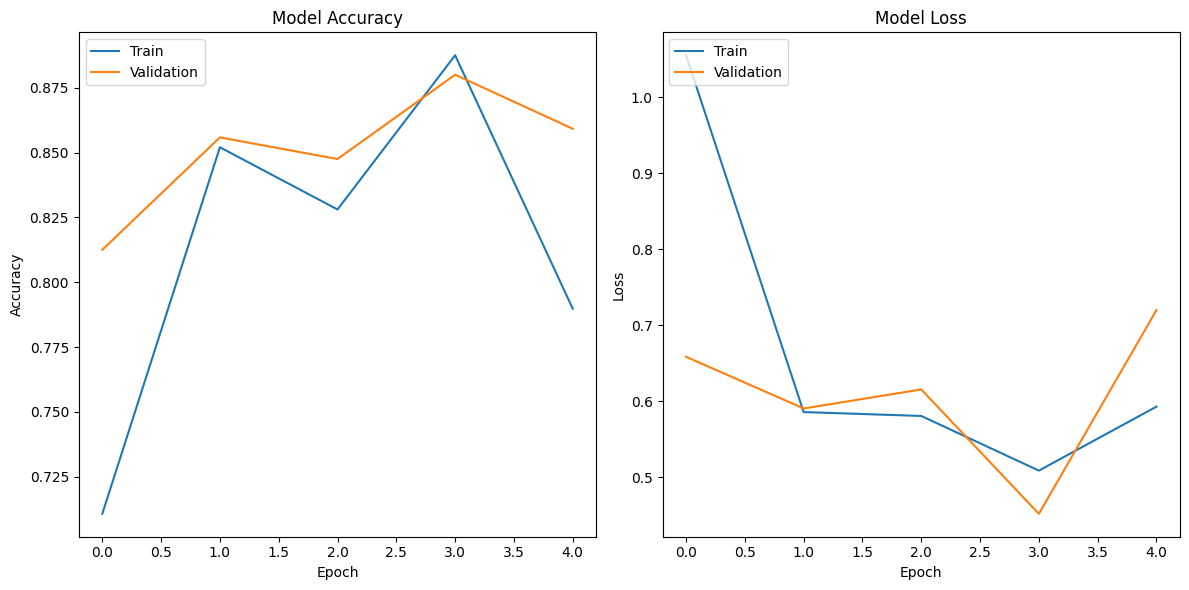

In [5]:
plot_training(train_history)

### Inference

In [11]:
df_test['prediction'] = df_test['text'].apply(make_preds)

### Evaluation

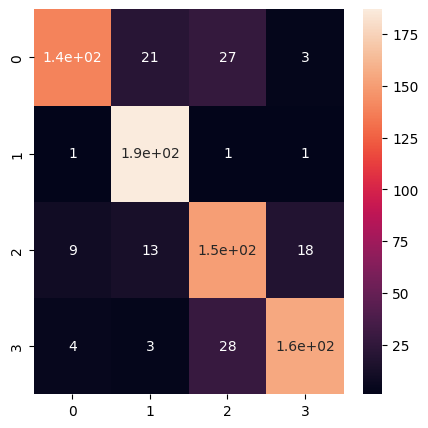

In [10]:
plot_confusion_matrix(df_test)

In [9]:
get_f1_score(df_test)

{'macro': 0.8290349188528386, 'micro': 0.8302631578947368}

### Problems encountered

* Learning rate too high
    * Solution: Changed from 1e-4 to 2e-5
* Shuffle not working correctly? .shuffle(1000) 
    * Solution: Changed .shuffle(1000) to .shuffle(100)